## Dynamic VaR with GARCH models

In this document we are going to use the library arch to estimate garch models, then we will use the models for the predictions and finally for the estimation of the value at risk.

### GARCH Model

A garch model is definded as:

$ GARCH(1,1):\sigma_t^2 = (1-\alpha-\beta)\omega_0 + \alpha\epsilon_{t-1}^2+\beta\sigma_{t-1}^2$

$\omega_0$= long term variance

$\epsilon$= independient brownian motions

$\alpha$= immidiate impact of the shock factor

$\beta$= duration of de impact factor

$\alpha +\beta$ < 1 the model is mean reverting to long term variance

$\alpha \ and \ \beta $ are positive parameters

In [1]:
#First, we are going to import all the necesary packages
from arch import arch_model
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import seaborn as sns
from scipy import stats

### Estimated Volatilties of QQQ with GARCH Models

We will get through different types of garch models to estimate the following concerns:

   -Conditional Volatilites 
    
   -Standarized Residuals
    
   -Volatilites Forecasts
 
We select the QQQ as the data for this work, and take a 5 years period which is common in finance.

In [2]:
ticker = 'QQQ' #NASDAQ 100 ETF Ticker
start = '2016-1-1'
end = '2021-1-1'

def get_price(x, start, end): #function to get historical prices 
    df=yf.download(x, start=start, end=end)
    return df

stock = get_price(ticker, start, end)
stock['Adj_Close_Ret'] = stock['Adj Close'].pct_change()*100 #convert prices to returns
stock = stock.dropna()

garch_model = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal') 
#We asume a constant mean, vol model GARCH, and a normal distribution for the residuals
garch_model_results = garch_model.fit(update_freq = 5, disp = 'off') #train the model 

print(garch_model_results.params) #get the paramaters

[*********************100%***********************]  1 of 1 completed
mu          0.119786
omega       0.061496
alpha[1]    0.183923
beta[1]     0.781442
Name: params, dtype: float64


In [3]:
print(garch_model_results.summary) #get the summary of the results 

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:          Adj_Close_Ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1858.01
Distribution:                  Normal   AIC:                           3724.03
Method:            Maximum Likelihood   BIC:                           3744.58
                                        No. Observations:                 1258
Date:                Thu, Jun 17 2021   Df Residuals:                     1257
Time:                        11:52:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1198  

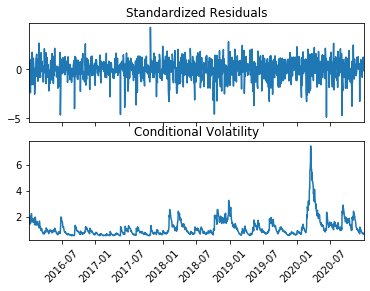

In [4]:
garch_model_results.plot() #plot the conditional volatility and the standarized residuals 
plt.xticks(rotation = 45)
plt.show()

In [5]:
garch_model_forecast = garch_model_results.forecast(horizon = 1) #1 step ahead forecast  
print(garch_model_forecast.variance[-1:]) 

                h.1
Date               
2020-12-31  0.44722


### Distribution of the residuals

We assume a normal distribution of the residuals. That is not true; in fact, it is well known that equity returns often have long tails and negative biases. So, first, we are going to graph the distribution to see the real shape of the bell, and then, we will change the distribution parameter to a "skewed" distribution that has the above considerations.

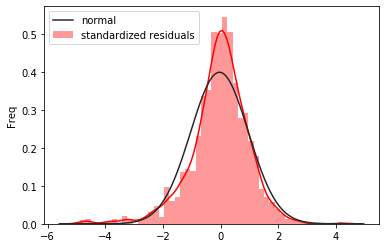

In [6]:
garch_model_std_resid = garch_model_results.resid / garch_model_results.conditional_volatility
sns.distplot(garch_model_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.ylabel('Freq')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In the graph above we can see that there is some negative skewness and long tails, especially in the negative residuals.

So next we will change the distribution parameter from "normal" to "skewt" and then we will compare both on a graph.

In [7]:
garch_model_sk = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1,
           mean = 'constant', vol = 'GARCH',  
           dist = 'skewt') #we change the distribution parameter to "skwet"
garch_model_sk_results = garch_model_sk.fit(update_freq = 5, disp = 'off')

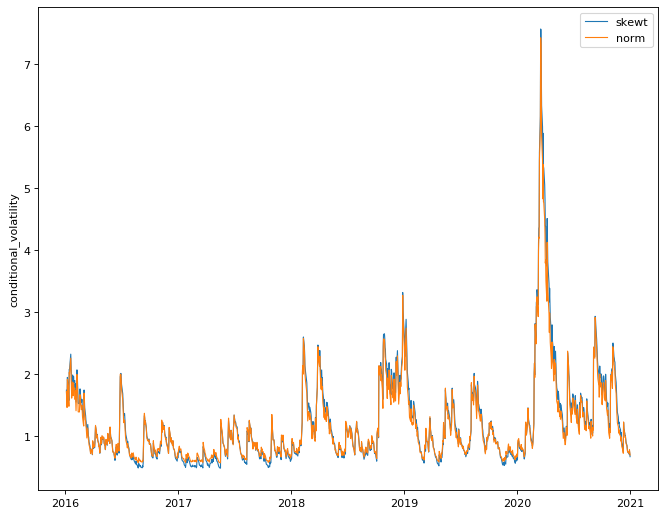

In [8]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(garch_model_sk_results.conditional_volatility, label = 'skewt', alpha = 1, lw = 1)
plt.plot(garch_model_results.conditional_volatility, label = 'norm', alpha = 1, lw = 1)
plt.ylabel('conditional_volatility')
plt.legend()
plt.show()

At first glance, there does not seem to be a great difference between the two estimates, furthermore, normal distributions tend to be preferred over others due to their simplicity and consequently lower computational requirements.

### Constant Mean Problem

Another problem is that we assumed that the mean of the returns is constant over time, the arch_model function allows us to change this to "AR"(autoregressive mean) or "Zero" in case we estimate the mean outside the model, for example, with an ARIMA model, which is beyond the scope of this document. 


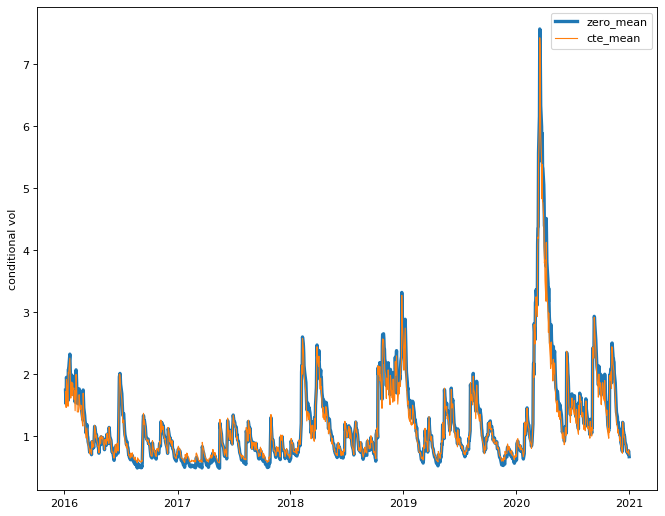

In [9]:
plt.figure(figsize=(10, 8), dpi=80)
garch_model_zero = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1,
           mean = 'AR', vol = 'GARCH',  #here we use an autoregressive mean model
           dist = 'skewt')
garch_model_zero_results = garch_model_zero.fit(update_freq = 5, disp = 'off')

plt.plot(garch_model_zero_results.conditional_volatility, label = 'zero_mean', alpha = 1, lw = 3)
plt.plot(garch_model_results.conditional_volatility, label = 'cte_mean', alpha = 1, lw = 1)
plt.ylabel('conditional vol')
plt.legend()
plt.show()

Again, we cannot see a significant difference in both charts. For simplicity, we will continue the rest of the script with a constant mean guess.

### Asymmetry in Financial Shocks

There is some asymmetry in financial shocks, higher volatilities are often associated with negative returns. There are several models that capture this particularity, here we will focus on two: GJR GARCH and EGARCH.

GRJ GARCH : 

 $ GJR \ GARCH(1,1):\sigma_t^2 = (1-\alpha-\beta)\omega_0 + (\alpha + \gamma_{t-1}I_{t-1})\epsilon_{t-1}^2+\beta\sigma_{t-1}^2$
 
 where : 
 
 $ if \ r_{t-1} < \mu \ \ then \ \ I_{t-1} = 1 $
 
 $ if \ r_{t-1} > \mu \ \ then \ \ I_{t-1} = 0 $
 
EGARCH :

It's an Exponential GARCH. This models the logarithm of the variance. The model also accommodates asymmetry in that negative shocks can have a bigger impact on volatility than positive shocks. 

In [10]:
gjr_garch_model = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1, o = 1, #We add the o = 1 parameter for a GJR GARCH model
           mean = 'constant', vol = 'GARCH',  
           dist = 'skewt')
egarch_model = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1, o = 1, #We add the o = 1 parameter and change vol for 'EGARCH'
           mean = 'constant', vol = 'EGARCH',                          #for EGARCH model
           dist = 'skewt')
gjr_garch_model_results = gjr_garch_model.fit(update_freq = 5, disp = 'off')
egarch_model_results = egarch_model.fit(update_freq = 5, disp = 'off')

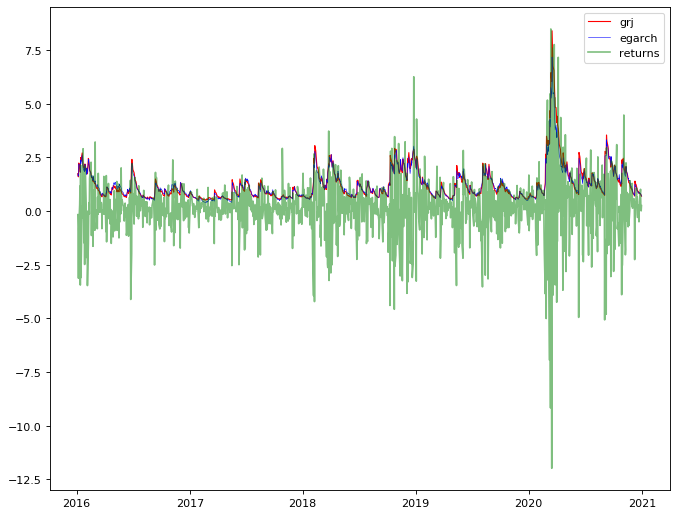

In [11]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(gjr_garch_model_results.conditional_volatility, label = 'grj', alpha = 1, lw = 1, c = 'r')
plt.plot(egarch_model_results.conditional_volatility, label = 'egarch', alpha = 1, lw = 0.5, c = 'b')
plt.plot(stock['Adj_Close_Ret'], alpha = 0.5, c = 'g', label = 'returns')
plt.legend()
plt.show()

It seems that both methods have similar behaviors. Let's see below other criteria for the selection of the model.

### AIC and BIC 

One thing that could be done is to compare the aic and bic given by the models, knowing that lower values are preferred, that is one way to evaluate the trade-off between the goodness of fit and the complexity of the model.

In [12]:
print('egarch aic and bic:') 
print('')
print(egarch_model_results.aic)
print(egarch_model_results.bic)
print('')
print('gjr_garch aic and bic:')
print('')
print(gjr_garch_model_results.aic)
print(gjr_garch_model_results.bic)
print('')
print('garch aic and bic:')
print('')
print(garch_model_results.aic)
print(garch_model_results.bic)

egarch aic and bic:

3551.136877797324
3587.0978268581466

gjr_garch aic and bic:

3550.714163390573
3586.6751124513958

garch aic and bic:

3724.029338752779
3744.5784525018207


The AIC and BIC for egarch and gjr_garch are roughtly the same.

### P - Values and T - Values
We can also see the statistical significance of the parameters given by the models and make a decision whether it is worth keeping it or not. For the porpuse of this document we will use a statistical signigicance of 5%, so our p-value must be greater than 0.05.
Another way is to get the t-value, which has to be greater than 2.

In [13]:
print('"\033[4mp-values of gjr garch:\033[0m')
print("\n") 
print(gjr_garch_model_results.pvalues)
print("\n")
print('"\033[4mp-values of egarch:\033[0m')
print("\n")
print(egarch_model_results.pvalues)
print("\n")
print('"\033[4mp-values of garch:\033[0m')
print("\n")
print(garch_model_results.pvalues)

"p-values of gjr garch:


mu          2.862593e-03
omega       8.102064e-04
alpha[1]    4.551449e-01
gamma[1]    1.132711e-06
beta[1]     0.000000e+00
nu          1.077458e-12
lambda      2.098723e-07
Name: pvalues, dtype: float64


"p-values of egarch:


mu          2.499984e-03
omega       1.177720e-01
alpha[1]    3.500470e-13
gamma[1]    3.606800e-13
beta[1]     0.000000e+00
nu          6.924648e-13
lambda      1.203533e-07
Name: pvalues, dtype: float64


"p-values of garch:


mu           2.804538e-05
omega        1.257278e-03
alpha[1]     2.565774e-06
beta[1]     6.438197e-104
Name: pvalues, dtype: float64


In [14]:
print('"\033[4mt-values of gjr garch:\033[0m')
print("\n") 
print(gjr_garch_model_results.tvalues)
print("\n")
print('"\033[4mt-values of egarch:\033[0m')
print("\n")
print(egarch_model_results.tvalues)
print("\n")
print('"\033[4mt-values of garch:\033[0m')
print("\n")
print(garch_model_results.tvalues)

"t-values of gjr garch:


mu           2.982121
omega        3.349284
alpha[1]     0.746865
gamma[1]     4.867059
beta[1]     39.207684
nu           7.120232
lambda      -5.190374
Name: tvalues, dtype: float64


"t-values of egarch:


mu            3.023343
omega         1.564194
alpha[1]      7.273594
gamma[1]     -7.269553
beta[1]     130.319128
nu            7.180915
lambda       -5.292958
Name: tvalues, dtype: float64


"t-values of garch:


mu           4.188783
omega        3.225557
alpha[1]     4.702832
beta[1]     21.647346
Name: tvalues, dtype: float64


We cannot reject the null hypothesis for omega in gjr garch and alpha in egarch. In the other hand, we have statistical significance in the particular parameters of the models as lambda and gamma.

### Garch Rolling Window Forecasting

In the next script we are going to forecast the variance of the QQQ through the two most common methods in time series split:

    Expanding Window 

    Fixed Rolling Window

Finally, we will compare each other according to the MAE and MSE criteria.

In [15]:
#Expanding Window

start = stock['Adj_Close_Ret'].shape[0] - 252*2
end = stock['Adj_Close_Ret'].shape[0] - 84

result = []
ind = []

for i in range(85): 
    egarch_model_results = egarch_model.fit(first_obs = start, 
                             last_obs = i + end, disp = 'off', update_freq = 5) #last_obs is not including
    temp_result = egarch_model_results.forecast(horizon = 1).variance.iloc[0] #we select the first period forecast for every loop
    result.append(temp_result['h.1'])                                         
    ind.append(temp_result.name)
df = pd.DataFrame(result, index = ind, columns = ['h.1'])

In [16]:
#Fixed Rolling Window

result1 = []
ind1 = []
for i in range(85):
    egarch_model_results1 = egarch_model.fit(first_obs = i + start, #Now we are adding i to the first obs with each loop 
                             last_obs = i + end, disp = 'off', update_freq = 5) #last_obs is not including
    temp_result1 = egarch_model_results1.forecast(horizon = 1).variance.iloc[0] #we select the first period forecast for every loop
    result1.append(temp_result1['h.1'])
    ind1.append(temp_result1.name)
df1 = pd.DataFrame(result1, index = ind1, columns = ['h.1'])

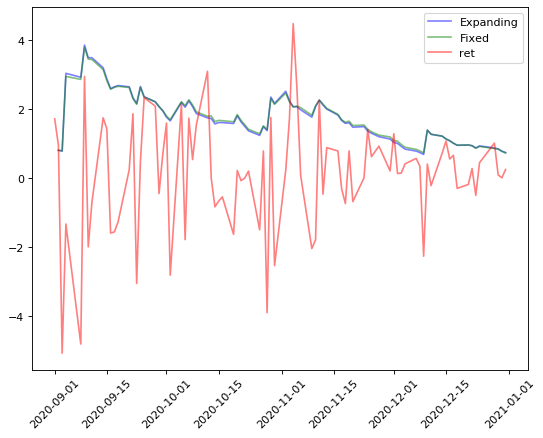

In [17]:
#Plot the both forecast charts vs returns
vol_df = np.sqrt(df.shift().dropna()) #note we shift the df because the 'h1' values are one step ahead of their row date
vol_df1 = np.sqrt(df1.shift().dropna())
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(vol_df, alpha = 0.5, c = 'b', label = 'Expanding')
plt.plot(vol_df1, alpha = 0.5, c = 'g', label = 'Fixed')
plt.plot(stock['Adj_Close_Ret'][end-1:], alpha = 0.5, c = 'r', label = 'ret')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

Fixed window tends to be more sensitive than expandig window to the latest news, which is logical because the window is always the same size and with each loop the training data is updated.

Next we will compare both methods by MAE and MSE.

In [18]:
real_var = stock['Adj_Close_Ret'].sub(stock['Adj_Close_Ret'].mean()).pow(2).iloc[end:]
MAE = mean_absolute_error(df[:-1], real_var)
MSE = mean_squared_error(df[:-1], real_var)
print('expanding window MAE, MSE')
print(MAE, MSE)
MAE1 = mean_absolute_error(df1[:-1], real_var)
MSE1 = mean_squared_error(df1[:-1], real_var)
print('fixed rolling window MAE, MSE')
print(MAE1,MSE1)

expanding window MAE, MSE
3.2327256885473448 27.002868238585382
fixed rolling window MAE, MSE
3.2385860687617445 26.757509557922297


The results are roughly the same. We have a better MSE in the fixed roling window and a better MAE in the expanding window method.

### Forecast Simulations

Another thing we can do is simulate 1000 possible paths. This can be done using the "simulation" or "bootstrap" parameters in the forecast method, then we can use an attribute that generates these routes. The simulation give us an insight of were is the concentration of futures volatilities. 

In [19]:
#We use the expanding window forecast method

for i in range(85): 
    egarch_model_results = egarch_model.fit(first_obs = start, 
                             last_obs = i + end, disp = 'off', update_freq = 5) #last_obs is not including

sim_forecasts = egarch_model_results.forecast(horizon=5, method='simulation') #we change the method to simulation
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_model_results.forecast(horizon=5, method='bootstrap') #we change the method to bootstrap
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

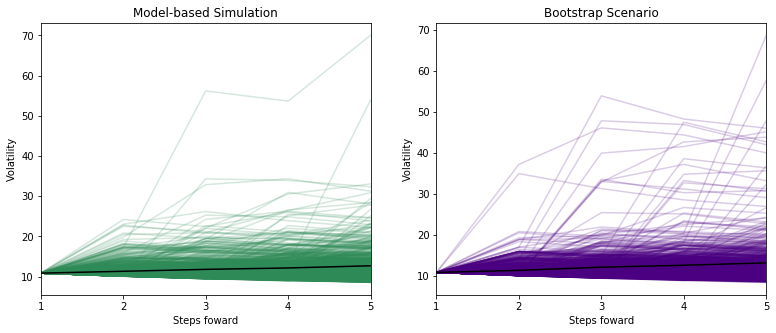

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

axes[0].plot(x, np.sqrt(252 * sim_paths), color='seagreen', alpha=0.2) #plot the path 
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]), #plot the mean forecast volatility
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)
axes[0].set_xlabel('Steps foward')
axes[0].set_ylabel('Volatility')

axes[1].plot(x, np.sqrt(252 * bs_paths), color='indigo', alpha=0.2) #plot the path
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]), #plot the mean forecast volatility
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
axes[1].set_xlabel('Steps foward')
axes[1].set_ylabel('Volatility')
plt.show()

### Value at Risk

Finally, a practic case for GARCH models is found in VaR. 

VaR definition: 

Value at Risk, or VaR for short, is a measure of the amount
that could be lost from a position, portfolio, desk, bank, etc.
VaR is generally understood to mean the maximum loss an
investment could incur at a given conﬁdence level over a
speciﬁed time horizon. There are other risk measures used
in practice but this is the simplest and most common.

Thanks to GARCH models we can estimate a dynamic VaR which is a more realistic assumption.

$ VaR = \mu + volatility.quantile$

We have two ways for estimate quantile:

    Parametric: Based on the assumed distribution of the residuals by the model
    
    Empirical: Based on the real distribution of the residuals
    
First, let's see the parametric VaR

### Parametric VaR

Note that we could do an expandig window forecast, just for script simplicity we won't.

In [21]:
arch_model_var = arch_model(stock['Adj_Close_Ret'], p = 1, q = 1, o = 1, mean = 'constant', vol = 'EGARCH', dist = 'skewt')
arch_model_var_results = arch_model_var.fit(disp = 'off', last_obs='2018-12-30')
arch_model_var_results_forecasts = arch_model_var_results.forecast(start = '2019-01-01')
mean = arch_model_var_results_forecasts.mean['2019':]
variance = arch_model_var_results_forecasts.variance['2019':]
quantiles = arch_model_var.distribution.ppf([0.01, 0.05], arch_model_var_results.params[5:7]) #parametric quantiles
print(quantiles)

[-2.86630144 -1.62293862]


In [22]:
value_at_risk = mean.values + np.sqrt(variance).values*quantiles[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns = ['1%', '5%'], index = variance.index)
value_at_risk.describe()

,1%,5%
count,505.000000,505.000000
mean,-3.556341,-1.984176
std,2.223149,1.258777
min,-17.820007,-10.060456
25%,-4.189943,-2.342930
50%,-3.032600,-1.687626
75%,-2.109625,-1.165026
max,-1.164171,-0.629697


[]

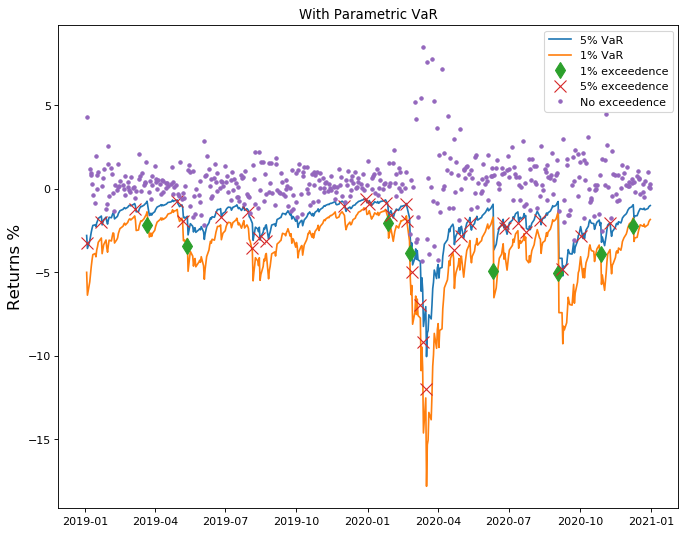

In [23]:
stock_95_bool = stock['Adj_Close_Ret']['2019-01-03':] > value_at_risk.shift().dropna()['5%']
stock_95 = stock_95 = stock['Adj_Close_Ret']['2019-01-03':][stock_95_bool]
stock_5_bool = (stock['Adj_Close_Ret']['2019-01-03':] < value_at_risk.shift().dropna()['5%']) & (stock['Adj_Close_Ret']['2019-01-03':] > value_at_risk.shift().dropna()['1%'])
stock_5 = stock['Adj_Close_Ret']['2019-01-03':][stock_5_bool]
stock_1_bool = stock['Adj_Close_Ret']['2019-01-03':] < value_at_risk.shift().dropna()['1%']
stock_1 = stock['Adj_Close_Ret']['2019-01-03':][stock_1_bool]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(value_at_risk['5%'].shift(), label = '5% VaR')
plt.plot(value_at_risk['1%'].shift(), label = '1% VaR')
plt.plot(stock_1, 'd', markersize = 10, label = '1% exceedence')
plt.plot(stock_5, 'x', markersize = 10, label = '5% exceedence')
plt.plot(stock_95, 'o',markersize = 3, label = 'No exceedence')
plt.ylabel('Returns %', size = 15)
plt.title('With Parametric VaR')
plt.legend()
plt.plot()

### Empirical VaR

In [24]:
conditional_volatility = arch_model_var_results.conditional_volatility
residuals = arch_model_var_results.resid
std_residuals = residuals/conditional_volatility
quantiles = std_residuals.quantile([.01, .05]) #empirical quantiles

In [25]:
value_at_risk = mean.values + np.sqrt(variance).values*quantiles[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns = ['1%', '5%'], index = variance.index)
value_at_risk.describe()

,1%,5%
count,505.000000,505.000000
mean,-4.077185,-1.998270
std,2.542638,1.267423
min,-20.390678,-10.130018
25%,-4.801842,-2.359488
50%,-3.478178,-1.699684
75%,-2.422563,-1.173494
max,-1.341238,-0.634488


[]

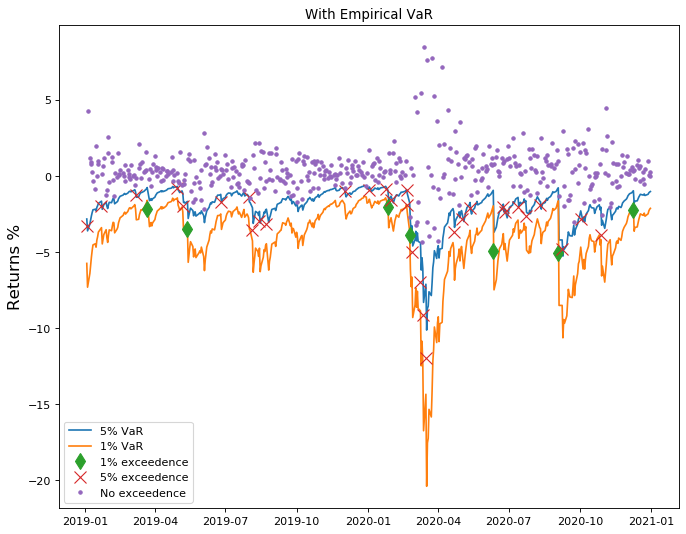

In [26]:
stock_95_bool = stock['Adj_Close_Ret']['2019-01-03':] > value_at_risk.shift().dropna()['5%']
stock_95 = stock_95 = stock['Adj_Close_Ret']['2019-01-03':][stock_95_bool]
stock_5_bool = (stock['Adj_Close_Ret']['2019-01-03':] < value_at_risk.shift().dropna()['5%']) & (stock['Adj_Close_Ret']['2019-01-03':] > value_at_risk.shift().dropna()['1%'])
stock_5 = stock['Adj_Close_Ret']['2019-01-03':][stock_5_bool]
stock_1_bool = stock['Adj_Close_Ret']['2019-01-03':] < value_at_risk.shift().dropna()['1%']
stock_1 = stock['Adj_Close_Ret']['2019-01-03':][stock_1_bool]

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(value_at_risk['5%'].shift(), label = '5% VaR')
plt.plot(value_at_risk['1%'].shift(), label = '1% VaR')
plt.plot(stock_1, 'd', markersize = 10, label = '1% exceedence')
plt.plot(stock_5, 'x', markersize = 10, label = '5% exceedence')
plt.plot(stock_95, 'o',markersize = 3, label = 'No exceedence')
plt.ylabel('Returns %', size = 15)
plt.title('With Empirical VaR')
plt.legend()
plt.plot()

In [27]:
#finally, let's see how the VaR fared

VaR_5p = (stock_5.shape[0] + stock_1.shape[0])/value_at_risk.shape[0]
print('real percentage of exceedence at VaR 5%:' + str(VaR_5p*100))

VaR_1p = (stock_1.shape[0])/value_at_risk.shape[0]
print('real percentage of exceedence at VaR 1%:' + str(VaR_1p*100))

real percentage of exceedence at VaR 5%:7.524752475247524
real percentage of exceedence at VaR 1%:1.3861386138613863


The actual exceedances are greater than the VaR predictions, our model is underestimating the risk, we could improve the results obtained using the rolling window methods shown above. We can also try some other garchs models like TGARCH for example